In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import resample
from sklearn.metrics import silhouette_score, plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer

# Data Preparation

In [2]:
data = pd.read_csv('data2020.student.csv')
data = data.loc[0:999,:]

data['Class'] = data['Class'].astype('category')

In [3]:
to_rem = []
num_cols = []
cat_cols = []

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 34 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   ID      1000 non-null   int64   
 1   Class   1000 non-null   category
 2   C1      995 non-null    float64 
 3   C2      996 non-null    float64 
 4   C3      1000 non-null   object  
 5   C4      1000 non-null   int64   
 6   C5      1000 non-null   object  
 7   C6      1000 non-null   int64   
 8   C7      1000 non-null   object  
 9   C8      1000 non-null   int64   
 10  C9      1000 non-null   int64   
 11  C10     1000 non-null   object  
 12  C11     1000 non-null   object  
 13  C12     1000 non-null   object  
 14  C13     1000 non-null   int64   
 15  C14     995 non-null    object  
 16  C15     1000 non-null   int64   
 17  C16     1000 non-null   object  
 18  C17     1000 non-null   object  
 19  C18     1000 non-null   object  
 20  C19     996 non-null    object  
 21  C20     1000 no

## Removing attributes with no information.

In [5]:
for col in data:
    if len(data[col].value_counts()) == 1:
        print(col)
        data = data.drop(col,axis=1)
        to_rem.append(col)

C15
C17
C21
C22


## Determining object attributes that should be categorical

In [6]:
for col in data.select_dtypes(include=object):
    print(col)
    data[col] = data[col].astype(object)

C3
C5
C7
C10
C11
C12
C14
C16
C18
C19
C23
C25
C27
C29
C31
C32


## Determining numeric attributes that should be categrocial

In [7]:
for col in data.select_dtypes(include=np.number):
    if data[col].nunique() < 6:
        print(col)
        data[col] = data[col].astype(object)

C2
C4
C9
C24
C28


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   ID      1000 non-null   int64   
 1   Class   1000 non-null   category
 2   C1      995 non-null    float64 
 3   C2      996 non-null    object  
 4   C3      1000 non-null   object  
 5   C4      1000 non-null   object  
 6   C5      1000 non-null   object  
 7   C6      1000 non-null   int64   
 8   C7      1000 non-null   object  
 9   C8      1000 non-null   int64   
 10  C9      1000 non-null   object  
 11  C10     1000 non-null   object  
 12  C11     1000 non-null   object  
 13  C12     1000 non-null   object  
 14  C13     1000 non-null   int64   
 15  C14     995 non-null    object  
 16  C16     1000 non-null   object  
 17  C18     1000 non-null   object  
 18  C19     996 non-null    object  
 19  C20     1000 non-null   int64   
 20  C23     1000 non-null   object  
 21  C24     1000 no

## Removing ID column

In [9]:
data = data.drop('ID',1)
to_rem.append('ID')

## Searching for dependence structures between numeric attributes

In [10]:
tmp = data.select_dtypes(include=np.number).copy()
tmp = tmp.dropna()

In [11]:
Q,R = np.linalg.qr(tmp.select_dtypes(include=np.number))
cols=[]
for i in range(0, len(R)):
    if abs(R[i,i]) < 1e-10:
        cols.append(data.select_dtypes(include=np.number).columns[i])

print('Columns: ' + str(data.select_dtypes(include=np.number).columns))
print('Dependent Columns: ' + str(cols))

pd.DataFrame(R)

Columns: Index(['C1', 'C6', 'C8', 'C13', 'C20', 'C26', 'C30'], dtype='object')
Dependent Columns: ['C6', 'C30']


,0,1,2,3,4,5,6
0,-742.374569,-7.423746e+02,-118672.370707,-136398.275604,-948.255813,-1.085716e+06,-1.186724e+05
1,0.000000,-1.613424e-13,-585.313103,2222.630197,4.748799,1.984396e+04,-5.853131e+02
2,0.000000,0.000000e+00,-68689.142485,-2677.276329,-56.297503,-2.452912e+04,-6.868914e+04
3,0.000000,0.000000e+00,0.000000,-87425.983024,-535.643648,-6.664145e+05,-5.784380e-13
4,0.000000,0.000000e+00,0.000000,0.000000,-420.421022,-1.151557e+05,-2.237495e-13
5,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-9.665657e+05,3.020302e-13
6,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,-1.734832e-11


From the QR decomposition we can observe that C6 is dependent on C1. Given C1 has missing entries we can remove it from the dataset in favour of C6.

In [12]:
to_rem.append('C1')
to_rem.append('C30')

data = data.drop(['C1','C30'],axis=1)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Class   1000 non-null   category
 1   C2      996 non-null    object  
 2   C3      1000 non-null   object  
 3   C4      1000 non-null   object  
 4   C5      1000 non-null   object  
 5   C6      1000 non-null   int64   
 6   C7      1000 non-null   object  
 7   C8      1000 non-null   int64   
 8   C9      1000 non-null   object  
 9   C10     1000 non-null   object  
 10  C11     1000 non-null   object  
 11  C12     1000 non-null   object  
 12  C13     1000 non-null   int64   
 13  C14     995 non-null    object  
 14  C16     1000 non-null   object  
 15  C18     1000 non-null   object  
 16  C19     996 non-null    object  
 17  C20     1000 non-null   int64   
 18  C23     1000 non-null   object  
 19  C24     1000 non-null   object  
 20  C25     1000 non-null   object  
 21  C26     1000 no

## Removing duplicate data

In [14]:
data = data.drop_duplicates()

## Assigning columns to categorical or numeric

In [15]:
for col in data:
    if pd.api.types.is_numeric_dtype(data[col]):
        num_cols.append(col)
    elif col != 'Class':
        cat_cols.append(col)

## Imputing large numbers of missing entries

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 900 entries, 0 to 899
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Class   900 non-null    category
 1   C2      896 non-null    object  
 2   C3      900 non-null    object  
 3   C4      900 non-null    object  
 4   C5      900 non-null    object  
 5   C6      900 non-null    int64   
 6   C7      900 non-null    object  
 7   C8      900 non-null    int64   
 8   C9      900 non-null    object  
 9   C10     900 non-null    object  
 10  C11     900 non-null    object  
 11  C12     900 non-null    object  
 12  C13     900 non-null    int64   
 13  C14     895 non-null    object  
 14  C16     900 non-null    object  
 15  C18     900 non-null    object  
 16  C19     896 non-null    object  
 17  C20     900 non-null    int64   
 18  C23     900 non-null    object  
 19  C24     900 non-null    object  
 20  C25     900 non-null    object  
 21  C26     900 non-

In [17]:
for col in data:
    if (data[col].isnull().sum() / data.shape[0]) > 0.05:
        if not pd.api.types.is_numeric_dtype(data[col]):
            data[col] = data[col].fillna('Unknown')
        else:
            data[col].fillna(0)

## Removing small amounts of missing entries

In [18]:
data = data.dropna(axis=0)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 887 entries, 0 to 899
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Class   887 non-null    category
 1   C2      887 non-null    object  
 2   C3      887 non-null    object  
 3   C4      887 non-null    object  
 4   C5      887 non-null    object  
 5   C6      887 non-null    int64   
 6   C7      887 non-null    object  
 7   C8      887 non-null    int64   
 8   C9      887 non-null    object  
 9   C10     887 non-null    object  
 10  C11     887 non-null    object  
 11  C12     887 non-null    object  
 12  C13     887 non-null    int64   
 13  C14     887 non-null    object  
 14  C16     887 non-null    object  
 15  C18     887 non-null    object  
 16  C19     887 non-null    object  
 17  C20     887 non-null    int64   
 18  C23     887 non-null    object  
 19  C24     887 non-null    object  
 20  C25     887 non-null    object  
 21  C26     887 non-

## Plotting Pairs

In [20]:
#sbplot = sb.pairplot(data, hue = 'Class',diag_kws={'bw': 1})
#sbplot.savefig('exploratory.jpg')

## Performing hot encoding

In [21]:
dataEnc = OneHotEncoder().fit(data[cat_cols].astype(str))
data = data.reset_index(drop=True)

In [22]:
data = data.drop(cat_cols,axis=1).join(pd.DataFrame(dataEnc.transform(data[cat_cols].astype(str)).toarray()))

## Resampling to adjust for class imbalance

In [23]:
data['Class'].value_counts()

0.0    639
1.0    248
Name: Class, dtype: int64

In [24]:
data = data.loc[data['Class']==0,:].append(resample(data.loc[data['Class']==1,:], replace = True, n_samples = 639, random_state = 76))
data['Class'].value_counts()

1.0    639
0.0    639
Name: Class, dtype: int64

## Building raw data formatter

In [ ]:
class raw_formatter():
    """Class to format data from file. Does not inherit from sklearn 
    for pipeline development because columns must be preserved and 
    rows are removed.
    """

    def __init__(self):
        self.numeric_imputer =
        self.categorical_imputer = 




## Splitting test and training 


In [25]:
train_data, test_data = train_test_split(data,test_size = 0.15, stratify = data['Class'], random_state = 21)

cLOF = LocalOutlierFactor(n_neighbors=6,metric='manhattan').fit_predict(train_data)
train_data = train_data.loc[cLOF==1,:]

## Standardising numeric training and test data

In [26]:
dataScaler = StandardScaler().fit(train_data[num_cols])

In [27]:
train_data[num_cols] = dataScaler.transform(train_data[num_cols])
test_data[num_cols] = dataScaler.transform(test_data[num_cols])

## Performing PCA on data

In [28]:
#Pairs plot prior to PCA

#tmp = num_cols.copy()
#tmp.append('Class')
#sbplot = sb.pairplot(train_data[tmp], hue = 'Class',diag_kws={'bw': 1})
#plt.suptitle('Data Prior to PCA Transformation',y=1.01)
#plt.savefig('Data Prior to PCA Transformation.jpg')

In [29]:
dataPCA = PCA().fit(train_data[num_cols])
print(num_cols)
print(dataPCA.explained_variance_ratio_)

['C6', 'C8', 'C13', 'C20', 'C26']
[0.3308917  0.21839175 0.19843299 0.17429299 0.07799057]


In [30]:
train_data[num_cols] = dataPCA.transform(train_data[num_cols])
test_data[num_cols] = dataPCA.transform(test_data[num_cols])

In [31]:
train_data[num_cols].cov()

,C6,C8,C13,C20,C26
C6,1.656105e+00,-6.363069e-17,-8.837596e-18,6.363069e-17,3.744931e-16
C8,-6.363069e-17,1.093045e+00,-3.075483e-16,-7.423581e-17,1.458203e-17
C13,-8.837596e-18,-3.075483e-16,9.931522e-01,-3.004783e-16,-3.336193e-17
C20,6.363069e-17,-7.423581e-17,-3.004783e-16,8.723321e-01,-2.297775e-17
C26,3.744931e-16,1.458203e-17,-3.336193e-17,-2.297775e-17,3.903409e-01


In [32]:
#Pairs plot post PCA

#sbplot = sb.pairplot(train_data[tmp], hue = 'Class',diag_kws={'bw': 1})
#plt.suptitle('Data Post PCA Transformation',y=1.01)
#plt.savefig('Data Post PCA Transformation.jpg')

## Performing cluster analysis

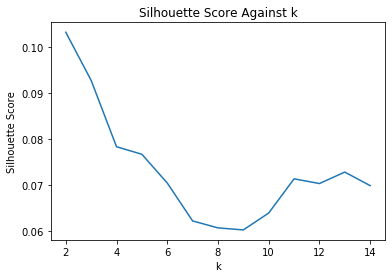

In [33]:
sil = []
ks = []
for k in range(2,15):
    kmeans = KMeans(n_clusters=k,random_state=67).fit(train_data)
    sil.append(silhouette_score(train_data,kmeans.labels_,metric='manhattan'))
    ks.append(k)
plt.plot(ks,sil)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Against k')
plt.show()


In [34]:
#kmeans = KMeans(n_clusters=2,random_state=67).fit(train_data)

In [35]:
#train_data['Cluster'] = kmeans.predict(train_data)
#test_data['Cluster'] = kmeans.predict(test_data)

Given that the silhouette plot demonstrates no global optimum clustering is removed from model.

# Analysis

In [36]:
cv = StratifiedKFold(n_splits=10, random_state=296)

In [37]:
train_data, test_data = train_test_split(data,test_size = 0.15, stratify = data['Class'], random_state = 21)

cLOF = LocalOutlierFactor(n_neighbors=6,metric='manhattan').fit_predict(train_data)
train_data = train_data.loc[cLOF==1,:]

x_train = train_data.drop('Class',axis=1)
y_train = train_data['Class']
x_test = test_data.drop('Class',axis=1)
y_test = test_data['Class']

## Building data pipelines

In [38]:
numerical_transform = Pipeline(steps=[
    ('Standardisation', StandardScaler()),
    ('Principal Component Analysis', PCA())
])

preprocessor = ColumnTransformer(transformers=[
    ('Numeric Transformations', numerical_transform, num_cols)
], remainder='passthrough', n_jobs=-1)

### Naive Bayes

In [39]:
cnb = Pipeline(steps=[
    ('Numeric Transformations', preprocessor),
    ('NB', GaussianNB())
])

cnb = cnb.fit(x_train,y_train)

In [40]:
sacc = cross_val_score(cnb, x_train, y_train, cv = cv,n_jobs=-1).mean()
tacc = sum(cnb.predict(x_test) == y_test)/len(y_test)

print('Logistic Regression')
print('Stratified Accuracy on Training Data: '+str(sacc))
print('Actual Accuracy on Test Data        : '+str(tacc))

print('\n')
print(classification_report(cnb.predict(x_test), y_test))

Logistic Regression
Stratified Accuracy on Training Data: 0.5228613861386139
Actual Accuracy on Test Data        : 0.5572916666666666


              precision    recall  f1-score   support

         0.0       0.11      1.00      0.21        11
         1.0       1.00      0.53      0.69       181

    accuracy                           0.56       192
   macro avg       0.56      0.77      0.45       192
weighted avg       0.95      0.56      0.67       192



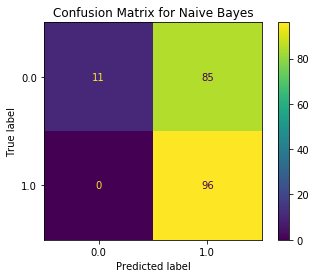

In [41]:
plot_confusion_matrix(cnb,x_test,y_test)
plt.title('Confusion Matrix for Naive Bayes')
plt.show()

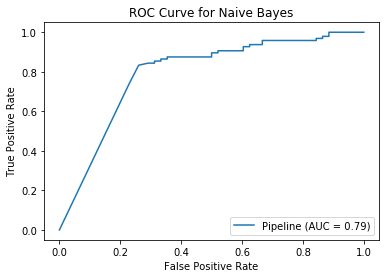

In [42]:
plot_roc_curve(cnb,x_test,y_test)
plt.title('ROC Curve for Naive Bayes')
plt.show()

### k-Nearest Neighbours Classifier

In [43]:
#Optimising model in region about default values
params = {
    'KNN__n_neighbors' : [i for i in range(5,10)],
    'KNN__leaf_size' : [i for i in range(25,35)]
}

knn = Pipeline(steps=[
    ('Numeric Transformations', preprocessor),
    ('KNN', KNeighborsClassifier())
])

gd_sr = GridSearchCV(estimator=knn,param_grid=params,cv=cv,n_jobs=-1)
gd_sr.fit(x_train,y_train)
knn = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'KNN__leaf_size': 25, 'KNN__n_neighbors': 5}


In [44]:
sacc = cross_val_score(knn, x_train, y_train, cv = cv,n_jobs=-1).mean()
tacc = sum(knn.predict(x_test) == y_test)/len(y_test)

print('k-Nearest Neighbours')
print('Stratified Accuracy on Training Data: '+str(sacc))
print('Actual Accuracy on Test Data        : '+str(tacc))

print('\n')
print(classification_report(knn.predict(x_test), y_test))

k-Nearest Neighbours
Stratified Accuracy on Training Data: 0.7564356435643564
Actual Accuracy on Test Data        : 0.7708333333333334


              precision    recall  f1-score   support

         0.0       0.72      0.80      0.76        86
         1.0       0.82      0.75      0.78       106

    accuracy                           0.77       192
   macro avg       0.77      0.77      0.77       192
weighted avg       0.78      0.77      0.77       192



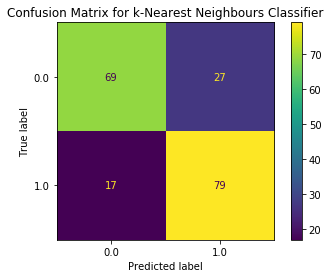

In [45]:
plot_confusion_matrix(knn,x_test,y_test)
plt.title('Confusion Matrix for k-Nearest Neighbours Classifier')
plt.show()

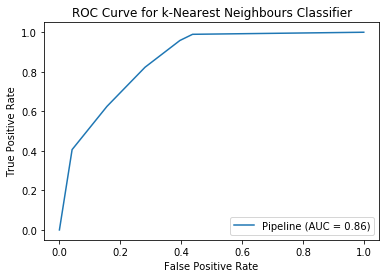

In [46]:
plot_roc_curve(knn,x_test,y_test)
plt.title('ROC Curve for k-Nearest Neighbours Classifier')
plt.show()

### Logistic Regression

In [47]:
#Optimising model in region about default values
params = {
    'LR__C' : [i/10 for i in range(0,11)]
}

clf = Pipeline(steps=[
    ('Numeric Transformations', preprocessor),
    ('LR', LogisticRegression(random_state=82))
])

gd_sr = GridSearchCV(estimator=clf,param_grid=params,cv=cv,n_jobs=-1)
gd_sr.fit(x_train,y_train)
clf = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'LR__C': 0.4}


In [48]:
sacc = cross_val_score(clf, x_train, y_train, cv = cv,n_jobs=-1).mean()
tacc = sum(clf.predict(x_test) == y_test)/len(y_test)

print('Logistic Regression')
print('Stratified Accuracy on Training Data: '+str(sacc))
print('Actual Accuracy on Test Data        : '+str(tacc))

print('\n')
print(classification_report(clf.predict(x_test), y_test))

Logistic Regression
Stratified Accuracy on Training Data: 0.7824158415841584
Actual Accuracy on Test Data        : 0.7864583333333334


              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79       103
         1.0       0.75      0.81      0.78        89

    accuracy                           0.79       192
   macro avg       0.79      0.79      0.79       192
weighted avg       0.79      0.79      0.79       192



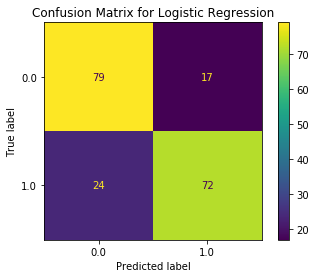

In [49]:
plot_confusion_matrix(clf,x_test,y_test)
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

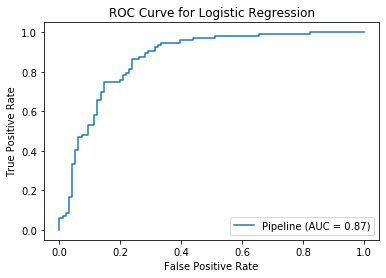

In [50]:
plot_roc_curve(clf,x_test,y_test)
plt.title('ROC Curve for Logistic Regression')
plt.show()

### Decision Tree

In [51]:
#Optimising model in region about default values
params = {
    'DT__criterion' : ['gini', 'entropy'],   
    'DT__min_samples_split' : [i for i in range(2,5)] 
}

ctr = Pipeline(steps=[
    ('Numeric Transformation', preprocessor),
    ('DT', DecisionTreeClassifier(random_state=387))
])

gd_sr = GridSearchCV(estimator=ctr,param_grid=params,cv=cv,n_jobs=-1)
gd_sr.fit(x_train,y_train)
ctr = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'DT__criterion': 'entropy', 'DT__min_samples_split': 3}


In [52]:
sacc = cross_val_score(ctr, x_train, y_train, cv = cv,n_jobs=-1).mean()
tacc = sum(ctr.predict(x_test) == y_test)/len(y_test)

print('Decision Tree')
print('Stratified Accuracy on Training Data: '+str(sacc))
print('Actual Accuracy on Test Data        : '+str(tacc))

print('\n')
print(classification_report(ctr.predict(x_test), y_test))

Decision Tree
Stratified Accuracy on Training Data: 0.864871287128713
Actual Accuracy on Test Data        : 0.8854166666666666


              precision    recall  f1-score   support

         0.0       0.85      0.91      0.88        90
         1.0       0.92      0.86      0.89       102

    accuracy                           0.89       192
   macro avg       0.89      0.89      0.89       192
weighted avg       0.89      0.89      0.89       192



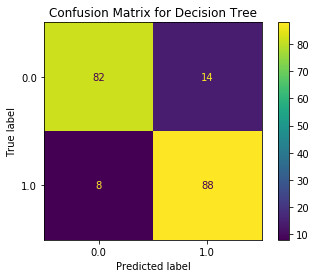

In [53]:
plot_confusion_matrix(ctr,x_test,y_test)
plt.title('Confusion Matrix for Decision Tree')
plt.show()

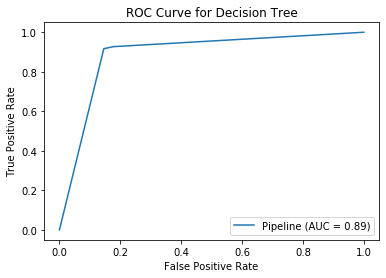

In [54]:
plot_roc_curve(ctr,x_test,y_test)
plt.title('ROC Curve for Decision Tree')
plt.show()

### Neural Network

In [55]:
#Optimising model in region about default values
params = {
    'NN__solver' : ['lbfgs', 'sgd', 'adam'],
    'NN__hidden_layer_sizes' : [(90,),(100,),(110,),(90,90),(100,100),(110,110),(90,90,90),(100,100,100),(110,110,110)]
}

cnn = Pipeline(steps=[
    ('Numeric Transformations', preprocessor),
    ('NN', MLPClassifier(random_state=29))
])

gd_sr = GridSearchCV(estimator=cnn,param_grid=params,cv=cv,n_jobs=-1)
gd_sr.fit(x_train,y_train)
cnn = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'NN__hidden_layer_sizes': (100, 100, 100), 'NN__solver': 'adam'}


In [56]:
sacc = cross_val_score(cnn, x_train, y_train, cv = cv,n_jobs=-1).mean()
tacc = sum(cnn.predict(x_test) == y_test)/len(y_test)

print('Neural Network')
print('Stratified Accuracy on Training Data: '+str(sacc))
print('Actual Accuracy on Test Data        : '+str(tacc))

print('\n')
print(classification_report(cnn.predict(x_test), y_test))

Neural Network
Stratified Accuracy on Training Data: 0.8946534653465348
Actual Accuracy on Test Data        : 0.8958333333333334


              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89        88
         1.0       0.94      0.87      0.90       104

    accuracy                           0.90       192
   macro avg       0.90      0.90      0.90       192
weighted avg       0.90      0.90      0.90       192



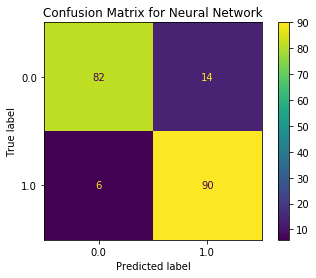

In [57]:
plot_confusion_matrix(cnn,x_test,y_test)
plt.title('Confusion Matrix for Neural Network')
plt.show()

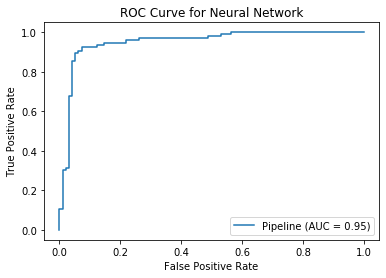

In [58]:
plot_roc_curve(cnn,x_test,y_test)
plt.title('ROC Curve for Neural Network')
plt.show()

### Random Forest

In [59]:
#Optimising model in region about default values
params = {
    'RF__n_estimators' : [i*10 for i in range(7,14)],
    'RF__criterion' : ['gini', 'entropy'],   
    'RF__min_samples_split' : [i for i in range(2,5)] 
}

crf = Pipeline(steps=[
    ('Numeric Transformations', preprocessor),
    ('RF', RandomForestClassifier(random_state=32))
])

gd_sr = GridSearchCV(estimator=crf,param_grid=params,cv=cv,n_jobs=-1)
gd_sr.fit(x_train,y_train)
crf = gd_sr.best_estimator_
print('Optimal Paramaters: ' + str(gd_sr.best_params_))

Optimal Paramaters: {'RF__criterion': 'gini', 'RF__min_samples_split': 3, 'RF__n_estimators': 80}


In [60]:
sacc = cross_val_score(crf, x_train, y_train, cv = cv,n_jobs=-1).mean()
tacc = sum(crf.predict(x_test) == y_test)/len(y_test)

print('Random Forest')
print('Stratified Accuracy on Training Data: '+str(sacc))
print('Actual Accuracy on Test Data        : '+str(tacc))

print('\n')
print(classification_report(crf.predict(x_test), y_test))

Random Forest
Stratified Accuracy on Training Data: 0.9055940594059406
Actual Accuracy on Test Data        : 0.9322916666666666


              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93        99
         1.0       0.92      0.95      0.93        93

    accuracy                           0.93       192
   macro avg       0.93      0.93      0.93       192
weighted avg       0.93      0.93      0.93       192



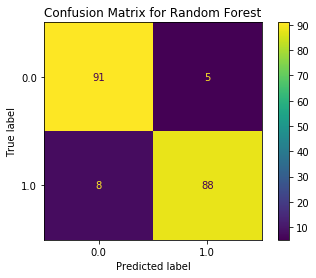

In [61]:
plot_confusion_matrix(crf, x_test, y_test)
plt.title('Confusion Matrix for Random Forest')
plt.show()

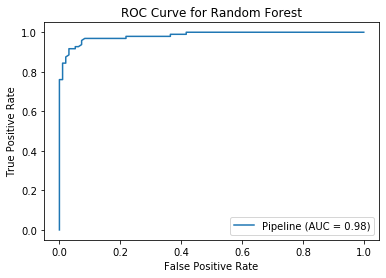

In [62]:
plot_roc_curve(crf,x_test,y_test)
plt.title('ROC Curve for Random Forest')
plt.show()

## Comparison of Model Performance Over Cross Validation

In [63]:
cv = StratifiedKFold(n_splits=10,random_state=857)
accs = {'trial' : [i for i in range(1,11)]}
f1s = {'trial' : [i for i in range(1,11)]}

In [64]:
accs['Random Forest - Accuracy'] = cross_val_score(estimator=crf,X=x_train,y=y_train,scoring='accuracy',cv=cv, n_jobs=-1)
f1s['Random Forest - F1'] = cross_val_score(estimator=crf,X=x_train,y=y_train,scoring='f1',cv=cv,n_jobs=-1)

accs['Neural Network - Accuracy'] = cross_val_score(estimator=cnn,X=x_train,y=y_train,scoring='accuracy',cv=cv,n_jobs=-1)
f1s['Neural Network - F1'] = cross_val_score(estimator=cnn,X=x_train,y=y_train,scoring='f1',cv=cv,n_jobs=-1)

accs['Decision Tree - Accuracy'] = cross_val_score(estimator=ctr,X=x_train,y=y_train,scoring='accuracy',cv=cv,n_jobs=-1)
f1s['Decision Tree - F1'] = cross_val_score(estimator=ctr,X=x_train,y=y_train,scoring='f1',cv=cv,n_jobs=-1)

accs['Logistic Regression - Accuracy'] = cross_val_score(estimator=clf,X=x_train,y=y_train,scoring='accuracy',cv=cv,n_jobs=-1)
f1s['Logistic Regression - F1'] = cross_val_score(estimator=clf,X=x_train,y=y_train,scoring='f1',cv=cv,n_jobs=-1)

accs['k-Nearest Neighbours - Accuracy'] = cross_val_score(estimator=knn,X=x_train,y=y_train,scoring='accuracy',cv=cv,n_jobs=-1)
f1s['k-Nearest Neighbours - F1'] = cross_val_score(estimator=knn,X=x_train,y=y_train,scoring='f1',cv=cv,n_jobs=-1)

accs['Naive Bayes - Accuracy'] = cross_val_score(estimator=cnb,X=x_train,y=y_train,scoring='accuracy',cv=cv,n_jobs=-1)
f1s['Naive Bayes - F1'] = cross_val_score(estimator=cnb,X=x_train,y=y_train,scoring='f1',cv=cv,n_jobs=-1)

accs = pd.DataFrame(accs)
f1s = pd.DataFrame(f1s)

In [65]:
accs

,trial,Random Forest - Accuracy,Neural Network - Accuracy,Decision Tree - Accuracy,Logistic Regression - Accuracy,k-Nearest Neighbours - Accuracy,Naive Bayes - Accuracy
0,1,0.900990,0.910891,0.811881,0.821782,0.792079,0.534653
1,2,0.920792,0.900990,0.930693,0.742574,0.762376,0.514851
2,3,0.831683,0.841584,0.861386,0.722772,0.732673,0.514851
3,4,0.920792,0.891089,0.851485,0.772277,0.782178,0.544554
4,5,0.950495,0.910891,0.881188,0.792079,0.752475,0.524752
5,6,0.881188,0.891089,0.792079,0.732673,0.742574,0.504950
6,7,0.890000,0.880000,0.870000,0.820000,0.740000,0.520000
7,8,0.900000,0.910000,0.880000,0.730000,0.710000,0.510000
8,9,0.940000,0.910000,0.930000,0.840000,0.830000,0.550000
9,10,0.920000,0.900000,0.840000,0.850000,0.720000,0.510000


In [66]:
f1s

,trial,Random Forest - F1,Neural Network - F1,Decision Tree - F1,Logistic Regression - F1,k-Nearest Neighbours - F1,Naive Bayes - F1
0,1,0.901961,0.914286,0.828829,0.826923,0.796117,0.680272
1,2,0.925926,0.910714,0.933333,0.750000,0.769231,0.675497
2,3,0.846847,0.857143,0.872727,0.745455,0.747664,0.666667
3,4,0.921569,0.893204,0.869565,0.767677,0.796296,0.680556
4,5,0.951456,0.914286,0.886792,0.792079,0.757282,0.680000
5,6,0.886792,0.895238,0.810811,0.742857,0.750000,0.666667
6,7,0.893204,0.884615,0.876190,0.816327,0.740000,0.675676
7,8,0.901961,0.912621,0.884615,0.737864,0.694737,0.657343
8,9,0.942308,0.914286,0.934579,0.836735,0.834951,0.685315
9,10,0.921569,0.903846,0.851852,0.848485,0.730769,0.662069


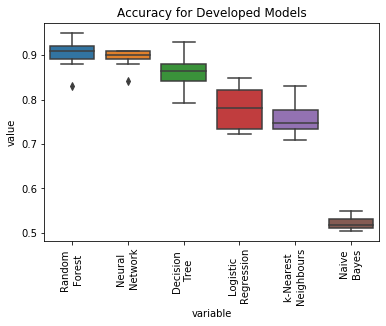

In [67]:
bplot = sb.boxplot(data=accs.melt('trial'),x='variable',y='value')
bplot.set_xticklabels(labels=['Random \nForest','Neural \nNetwork','Decision \nTree','Logistic \nRegression','k-Nearest \nNeighbours','Naive \nBayes'],rotation=90)
plt.title('Accuracy for Developed Models')
plt.show()

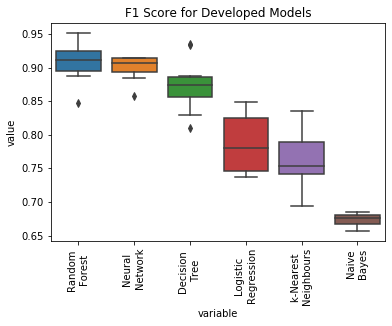

In [68]:
bplot = sb.boxplot(data=f1s.melt('trial'),x='variable',y='value')
bplot.set_xticklabels(labels=['Random \nForest','Neural \nNetwork','Decision \nTree','Logistic \nRegression','k-Nearest \nNeighbours','Naive \nBayes'],rotation=90)
plt.title('F1 Score for Developed Models')
plt.show()

## TODO 
- Add executable to perform analysis automatically

In [69]:
num_cols

['C6', 'C8', 'C13', 'C20', 'C26']

In [70]:
cat_cols

['C2',
 'C3',
 'C4',
 'C5',
 'C7',
 'C9',
 'C10',
 'C11',
 'C12',
 'C14',
 'C16',
 'C18',
 'C19',
 'C23',
 'C24',
 'C25',
 'C27',
 'C28',
 'C29',
 'C31',
 'C32']

In [71]:
to_rem

['C15', 'C17', 'C21', 'C22', 'ID', 'C1', 'C30']